# EMBS-BHI-2025: Robust and Reproducible AI Tutorial

Tutorial instructors: Ernest Namdar and Pascal Tyrrell

The dataset used in this tutorial is adopted from Openradiomics (BraTS 2020).
https://pubmed.ncbi.nlm.nih.gov/40760408/

This notebook focuses on probability calibration for a Random Forest classifier using a single train/test split.

## Why Calibration Matters
Classification probabilities should reflect the true likelihood of an event. Calibration plots (also called reliability diagrams) compare predicted probabilities with observed frequencies; points near the diagonal indicate well-calibrated models while deviations highlight over- or under-confidence.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.calibration import calibration_curve

SEED = 0
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# Comment out this cell if you run the code locally
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --- Set working directory ---
import os

project_path = '/content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code'

# Change the working directory
os.chdir(project_path)

# Verify
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/EMBS_BHI_2025_Tutorial_Robust_and_Reproducible_AI/Part1-Classification/code


## Load and Prepare the Dataset
We reuse the radiomics dataset packaged with the tutorial. Metadata columns are dropped so the model only sees features.

In [3]:
DATA_PATH = '../data/Radiomics_NoNormalization_Whole_Tumor_T1CE.csv'

df = pd.read_csv(DATA_PATH)

In [4]:
df

,Lesion_ID,Group,Group_label,Patient_ID,Normalization,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,...,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
0,1,LGG,0,BraTS20_Training_264,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,257.875481,0.002917,7.129410,0.068842,1.065569e+04,1.857225,0.001056,402.594060,0.057651,0.400334
1,2,LGG,0,BraTS20_Training_333,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,31400.796681,0.000034,9.194488,0.550131,5.733321e+00,0.037253,0.000198,615308.179535,0.086944,37.474497
2,3,LGG,0,BraTS20_Training_290,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,687.290391,0.001712,7.892693,0.031033,4.019240e+05,1.891263,0.000142,1546.563118,0.005046,0.767814
3,4,LGG,0,BraTS20_Training_269,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,14.038038,0.055507,5.427283,0.004712,1.996953e+06,34.988012,0.000462,11.145451,0.005164,0.024456
4,5,LGG,0,BraTS20_Training_263,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,799.617583,0.000725,7.988775,0.117867,5.486999e+03,0.454818,0.000960,2447.225716,0.047115,3.002776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,365,HGG,1,BraTS20_Training_207,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,250.731263,0.003331,7.412216,0.055957,3.441931e+04,2.054098,0.000544,586.352427,0.032293,0.458392
365,366,HGG,1,BraTS20_Training_192,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,994.351189,0.001169,7.464253,0.117230,3.670582e+04,2.321920,0.000186,2915.452880,0.036619,0.935791
366,367,HGG,1,BraTS20_Training_007,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,1122.955449,0.001012,7.625789,0.249371,2.043887e+03,0.674250,0.000442,8412.504297,0.069797,2.593628
367,368,HGG,1,BraTS20_Training_235,NoNormalization,Whole_Tumor,T1CE,v3.0.1,1.20.3,2.1.1,...,2511.604246,0.000511,8.163777,0.277927,3.428665e+03,1.032603,0.000163,17448.583739,0.088018,1.784128


In [5]:
y = df['Group_label']
X = df.drop(columns=[
    'Lesion_ID', 'Group', 'Group_label', 'Patient_ID',
    'Normalization', 'Subregion', 'Sequence'
] + [col for col in df.columns if col.startswith('diag')])

lb = LabelBinarizer()
y_bin = lb.fit_transform(y).ravel()

print('Feature matrix shape:', X.shape)
print('Label vector shape:', y.shape)

Feature matrix shape: (369, 1688)
Label vector shape: (369,)


There are 369 patients in the dataset (BraTS 2020) and 1688 radiomics features were extracted for each patient.

## Train/Test Split and Model Training
We keep the setup simple: one stratified split with 25% held out for evaluation.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.25, random_state=SEED, stratify=y_bin
)
clf = RandomForestClassifier(random_state=SEED)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)
print(f'AUROC: {auc:.3f}')
print(f'Brier score: {brier:.3f}')

AUROC: 0.938
Brier score: 0.081


## Deriving the Calibration Curve
A calibration curve bins predicted probabilities and computes the observed positive fraction within each bin. Plotting those fractions against the average predicted probability provides a visual summary of calibration.

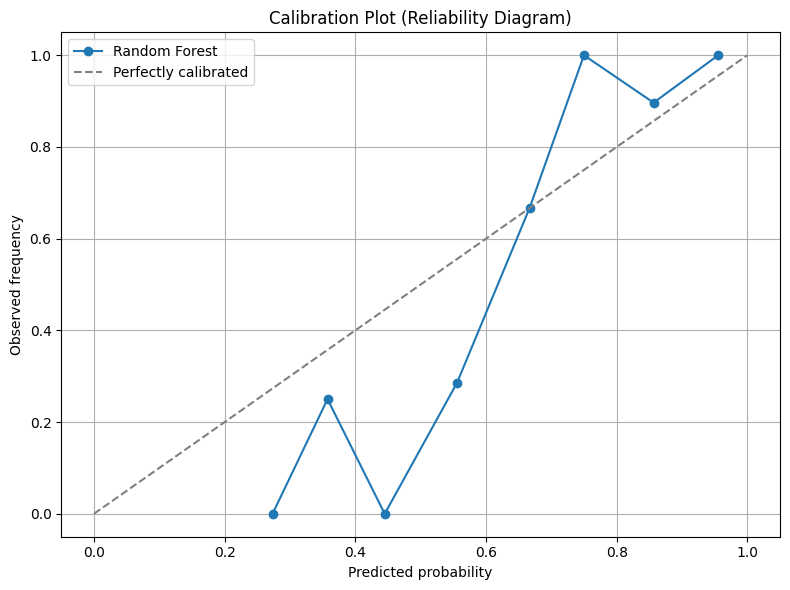

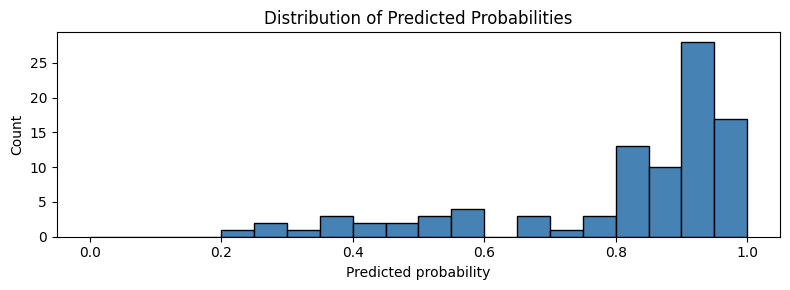

In [7]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration Plot (Reliability Diagram)')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(y_proba, bins=20, range=(0, 1), color='steelblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

| Pattern                         | Meaning                                                                            | Example                      |
| ------------------------------- | ---------------------------------------------------------------------------------- | ---------------------------- |
| Curve is **below** the diagonal | Model is **overconfident** (predicted probabilities are too high)                 | Predicted 0.9 → actually 0.7 |
| Curve is **above** the diagonal | Model is **underconfident** (predicted probabilities are too low)                 | Predicted 0.3 → actually 0.5 |
| Curve is **nonlinear / wavy**   | Model calibration varies by region of probability; needs more flexible correction. |                              |


Main strategies:
- train another model to for probability calibration (usually regression). [works well for non-NN model]
- adjust the design and retrain the model. [more often used for NNs]